In [23]:
import sys
import pdb
# sys.path.insert allows us to define paths from where we can import .py files
#sys.path.insert(0, 'D://Users//jvdputte//Documents//Work//Educational//5LSM0//jupyter_scripts//assets') 
sys.path.insert(0, 'C://Users//s141010//Documents//school//master//CNN//assets')
import mnist
import numpy as np
import matplotlib.pyplot as plt

We will load the mnist dataset just as in assignment 1

In [24]:
X_train, y_train, X_test, y_test = mnist.load()

Lets plot some examples of the handwritten digits

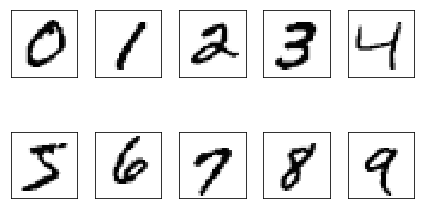

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Lets look at what different samples of the same digit looks like. You can change the label to look at other examples.

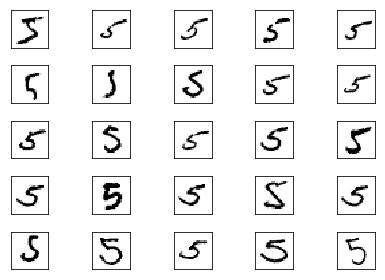

In [26]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 5][i].reshape(28, 28) # change the label to look at other digits
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

### Q1. Evaluate several examples of the digits. Name three data-augmentation operations that make sense for this data set.

<span style="color:red">''' it would not be stange to think that these numbers are written with a different color pen, paper or different pressure. Thus the color and the brightness of the image could be changed. Different structre paper could be imitaded by noise (whit a small grain) or bubbely filters. '''</span>.

## Multi-layer perceptron
In this section we are going to implement our own multi-layer perceptron, including backpropagation. Carefully read all the hints in the code. The supplementary file will elaborate more on the details of the algorithm.

In [70]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    # the onehot function encodes labels into onehot representation e.g. with 3 labels, 0->[1,0,0], 1->[0,1,0], 2->[0,0,1]
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        sigmoid= 1/(1+np.exp(-z))        
        return sigmoid

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]-> [n_samples, n_hidden]
        z_h=np.dot(X,self.w_h)
 
        # step 2: activation of hidden layer
        a_h=self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        z_out=np.dot(a_h,self.w_out)

        # step 4: activation output layer
        a_out=self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        
        cost = -np.sum(y_enc*np.log(output)+(1-y_enc)*np.log(1-output))
        cost = cost_temp+self.l2*np.sum(np.square(self.w_out))

        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out=self._forward(X)
        y_pred=np.argmax(a_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]
        
        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))
        
        # create dictionary to keep track of training scores
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        # convert y to one-hot encoding
        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)
            
            # this for loop takes care of the batching process. Every iteration several samples are fed through the network in one go.
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # calculate error vector of the output layer: sigma_out, [n_samples, n_classlabels]
                sigma_out=a_out-y_train_enc[batch_idx]
                
                
                # calculate derivative of the sigmoid activation function:
                # sigmoid_derivative_h, [n_samples, n_hidden]
                sigmoid_derivative_h=np.multiply(a_h, (1-a_h))
                
                # Calculate the error term of the hidden layer: sigma_h, 
                #[n_samples, n_classlabels] dot [n_classlabels, n_hidden] -> [n_samples, n_hidden]
                sigma_h=np.multiply(np.dot(sigma_out,np.transpose(self.w_out)),sigmoid_derivative_h)

                # Calculate the gradients of the weights in the hidden layer
                # [n_features, n_samples] dot [n_samples, n_hidden] -> [n_features, n_hidden]
                grad_w_h=np.dot(np.transpose(X_train[batch_idx]),sigma_h)
                
                # calculate gradients of the biases in the hidden layer (freebee)
                grad_b_h = np.sum(sigma_h, axis=0)#/len(batch_idx)

                # Calculate the gradients of the weights in the output layer
                # [n_hidden, n_samples] dot [n_samples, n_classlabels] -> [n_hidden, n_classlabels]
                grad_w_out=np.dot(a_h,sigma_out) 
                
                # calculate the gradient of the biases in the output layer
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /X_valid.shape[0])

            sys.stderr.write('\r' + '{}/{} | Cost: {:.1f} | Train/Valid Acc.: {:.2f}%/{:.2f}% '.format(i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

Lets initialize the network and feed it training and validation data (55000 samples are used for training, remaining 5000 samples are used for validation).
### Q2. Why do we define a validation set even though we already have a test set of unseen samples? Explain your answer.
<span style="color:red">''' Write down the answer in the cell markdown here (doubleclick the text)  '''</span>.

In [71]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.0001, 
                  epochs=20, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

98966.75697164824


1/20 | Cost: 98966.8 | Train/Valid Acc.: 78.54%/81.28% 

84846.99749887011


2/20 | Cost: 84847.0 | Train/Valid Acc.: 83.70%/86.07% 

76235.97525924783


3/20 | Cost: 76236.0 | Train/Valid Acc.: 85.80%/87.99% 

70620.88483368837


4/20 | Cost: 70620.9 | Train/Valid Acc.: 87.09%/89.15% 

66234.30495281894


5/20 | Cost: 66234.3 | Train/Valid Acc.: 88.12%/89.74% 

63406.800127295195


6/20 | Cost: 63406.8 | Train/Valid Acc.: 88.23%/89.75% 

60735.0116031823


7/20 | Cost: 60735.0 | Train/Valid Acc.: 88.85%/90.41% 

58383.570647918765


8/20 | Cost: 58383.6 | Train/Valid Acc.: 89.24%/90.58% 

56261.91665272183


9/20 | Cost: 56261.9 | Train/Valid Acc.: 89.76%/91.00% 

54025.276185575516


10/20 | Cost: 54025.3 | Train/Valid Acc.: 89.96%/91.14% 

52229.67946367466


11/20 | Cost: 52229.7 | Train/Valid Acc.: 90.32%/91.19% 

51059.91495111147


12/20 | Cost: 51059.9 | Train/Valid Acc.: 90.32%/91.61% 

49612.869444526055


13/20 | Cost: 49612.9 | Train/Valid Acc.: 90.36%/91.11% 

48445.69006895679


14/20 | Cost: 48445.7 | Train/Valid Acc.: 90.80%/91.70% 

47387.61760725558


15/20 | Cost: 47387.6 | Train/Valid Acc.: 90.89%/91.68% 

46530.44361680211


16/20 | Cost: 46530.4 | Train/Valid Acc.: 90.95%/91.74% 

45412.76810580326


17/20 | Cost: 45412.8 | Train/Valid Acc.: 91.02%/91.59% 

44838.932463739366


18/20 | Cost: 44838.9 | Train/Valid Acc.: 91.21%/91.88% 

43894.99758167296


19/20 | Cost: 43895.0 | Train/Valid Acc.: 91.33%/91.96% 

42802.305918559054


20/20 | Cost: 42802.3 | Train/Valid Acc.: 91.47%/92.09% 

Lets plot the cost and the training/validation accuracy for 20 epochs. We can see the cost is decreasing and accuracy of both the training and validation is going up.

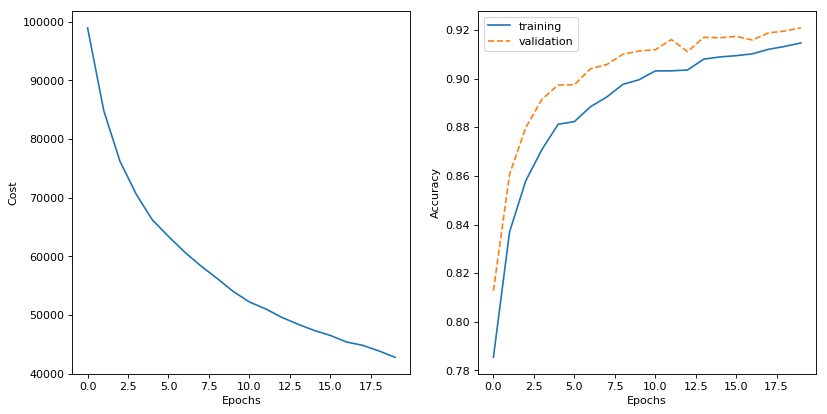

In [72]:
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,2,1)
ax.plot(range(nn.epochs), nn.eval_['cost'])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs')

ax = plt.subplot(1,2,2)
ax.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
ax.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()


## Q3. The validation accuracy is higher than the training accuracy. What does this say about the quality of the model?
<span style="color:red">''' Write down the answer in the cell markdown here (doubleclick the text)  '''</span>.

In [73]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.0001, 
                  epochs=200, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=123)

nn.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

96419.66917385503


1/200 | Cost: 96419.7 | Train/Valid Acc.: 81.11%/83.50% 

81560.1681220989


2/200 | Cost: 81560.2 | Train/Valid Acc.: 84.85%/86.65% 

74860.22638259486


3/200 | Cost: 74860.2 | Train/Valid Acc.: 86.65%/88.27% 

69681.71254873562


4/200 | Cost: 69681.7 | Train/Valid Acc.: 87.49%/88.92% 

65666.70776169676


5/200 | Cost: 65666.7 | Train/Valid Acc.: 88.09%/89.34% 

61784.54128324941


6/200 | Cost: 61784.5 | Train/Valid Acc.: 88.76%/89.87% 

59714.51182985868


7/200 | Cost: 59714.5 | Train/Valid Acc.: 88.80%/89.96% 

56550.96351043902


8/200 | Cost: 56551.0 | Train/Valid Acc.: 89.18%/90.31% 

54334.2526418648


9/200 | Cost: 54334.3 | Train/Valid Acc.: 89.58%/90.84% 

52633.4882082632


10/200 | Cost: 52633.5 | Train/Valid Acc.: 89.94%/90.93% 

51119.77672332963


11/200 | Cost: 51119.8 | Train/Valid Acc.: 90.08%/91.00% 

49505.12648260733


12/200 | Cost: 49505.1 | Train/Valid Acc.: 90.14%/91.09% 

48183.41305407254


13/200 | Cost: 48183.4 | Train/Valid Acc.: 90.37%/91.19% 

46979.43849945503


14/200 | Cost: 46979.4 | Train/Valid Acc.: 90.45%/91.17% 

46275.43821479168


15/200 | Cost: 46275.4 | Train/Valid Acc.: 90.60%/91.55% 

45244.996525517985


16/200 | Cost: 45245.0 | Train/Valid Acc.: 90.74%/91.71% 

43872.462443579294


17/200 | Cost: 43872.5 | Train/Valid Acc.: 90.96%/91.74% 

43061.91728597358


18/200 | Cost: 43061.9 | Train/Valid Acc.: 91.00%/91.71% 

41947.22516947433


19/200 | Cost: 41947.2 | Train/Valid Acc.: 91.18%/92.05% 

41495.57935459253


20/200 | Cost: 41495.6 | Train/Valid Acc.: 91.03%/91.87% 

40879.41146418945


21/200 | Cost: 40879.4 | Train/Valid Acc.: 91.28%/92.17% 

40308.23103771691


22/200 | Cost: 40308.2 | Train/Valid Acc.: 91.32%/92.06% 

39546.25383314306


23/200 | Cost: 39546.3 | Train/Valid Acc.: 91.47%/92.37% 

38977.5190080926


24/200 | Cost: 38977.5 | Train/Valid Acc.: 91.55%/92.17% 

38399.18703774951


25/200 | Cost: 38399.2 | Train/Valid Acc.: 91.68%/92.36% 

37943.41034624177


26/200 | Cost: 37943.4 | Train/Valid Acc.: 91.85%/92.56% 

37554.01584009838


27/200 | Cost: 37554.0 | Train/Valid Acc.: 91.72%/92.45% 

37314.155308094785


28/200 | Cost: 37314.2 | Train/Valid Acc.: 91.77%/92.22% 

36347.551567403156


29/200 | Cost: 36347.6 | Train/Valid Acc.: 91.91%/92.35% 

35863.109673164996


30/200 | Cost: 35863.1 | Train/Valid Acc.: 92.22%/92.55% 

35515.908264766294


31/200 | Cost: 35515.9 | Train/Valid Acc.: 91.99%/92.54% 

35139.262711766205


32/200 | Cost: 35139.3 | Train/Valid Acc.: 92.05%/92.62% 

34764.43031682126


33/200 | Cost: 34764.4 | Train/Valid Acc.: 92.21%/92.81% 

34733.366782216086


34/200 | Cost: 34733.4 | Train/Valid Acc.: 92.12%/92.66% 

34175.43503683638


35/200 | Cost: 34175.4 | Train/Valid Acc.: 92.23%/92.75% 

33712.75123994805


36/200 | Cost: 33712.8 | Train/Valid Acc.: 92.30%/92.73% 

33690.286223024676


37/200 | Cost: 33690.3 | Train/Valid Acc.: 92.30%/92.96% 

33134.38798437732


38/200 | Cost: 33134.4 | Train/Valid Acc.: 92.39%/92.79% 

32767.856417931645


39/200 | Cost: 32767.9 | Train/Valid Acc.: 92.42%/92.89% 

32401.952389047226


40/200 | Cost: 32402.0 | Train/Valid Acc.: 92.58%/92.91% 

32504.453379876464


41/200 | Cost: 32504.5 | Train/Valid Acc.: 92.48%/93.00% 

32374.121976418883


42/200 | Cost: 32374.1 | Train/Valid Acc.: 92.47%/93.00% 

31855.304782957766


43/200 | Cost: 31855.3 | Train/Valid Acc.: 92.59%/93.08% 

31569.513791961635


44/200 | Cost: 31569.5 | Train/Valid Acc.: 92.56%/93.10% 

31151.218133381815


45/200 | Cost: 31151.2 | Train/Valid Acc.: 92.67%/92.97% 

31174.173900747806


46/200 | Cost: 31174.2 | Train/Valid Acc.: 92.67%/93.09% 

30775.03911223561


47/200 | Cost: 30775.0 | Train/Valid Acc.: 92.60%/93.01% 

30219.829463003003


48/200 | Cost: 30219.8 | Train/Valid Acc.: 92.87%/93.15% 

30132.76283577806


49/200 | Cost: 30132.8 | Train/Valid Acc.: 92.89%/92.92% 

29935.871540090626


50/200 | Cost: 29935.9 | Train/Valid Acc.: 92.89%/93.28% 

29864.95026808172


51/200 | Cost: 29865.0 | Train/Valid Acc.: 92.88%/93.18% 

29751.46481807412


52/200 | Cost: 29751.5 | Train/Valid Acc.: 92.87%/93.19% 

29310.196425462615


53/200 | Cost: 29310.2 | Train/Valid Acc.: 93.07%/93.38% 

29713.199568545802


54/200 | Cost: 29713.2 | Train/Valid Acc.: 92.96%/93.37% 

29201.844887940977


55/200 | Cost: 29201.8 | Train/Valid Acc.: 93.08%/93.35% 

28786.283186145305


56/200 | Cost: 28786.3 | Train/Valid Acc.: 93.22%/93.21% 

28819.15320021831


57/200 | Cost: 28819.2 | Train/Valid Acc.: 93.06%/93.42% 

28387.528107613547


58/200 | Cost: 28387.5 | Train/Valid Acc.: 93.27%/93.70% 

28412.182092698153


59/200 | Cost: 28412.2 | Train/Valid Acc.: 93.23%/93.50% 

28046.969993105486


60/200 | Cost: 28047.0 | Train/Valid Acc.: 93.27%/93.44% 

28444.870771973514


61/200 | Cost: 28444.9 | Train/Valid Acc.: 93.23%/93.31% 

28290.76986869061


62/200 | Cost: 28290.8 | Train/Valid Acc.: 93.20%/93.63% 

27763.511537746635


63/200 | Cost: 27763.5 | Train/Valid Acc.: 93.36%/93.57% 

27259.778074931157


64/200 | Cost: 27259.8 | Train/Valid Acc.: 93.39%/93.82% 

27538.84953184894


65/200 | Cost: 27538.8 | Train/Valid Acc.: 93.26%/93.52% 

27595.42079765978


66/200 | Cost: 27595.4 | Train/Valid Acc.: 93.36%/93.53% 

26807.844423161787


67/200 | Cost: 26807.8 | Train/Valid Acc.: 93.44%/93.71% 

27202.249327720136


68/200 | Cost: 27202.2 | Train/Valid Acc.: 93.35%/93.63% 

26899.076540079426


69/200 | Cost: 26899.1 | Train/Valid Acc.: 93.38%/93.70% 

26852.919082277404


70/200 | Cost: 26852.9 | Train/Valid Acc.: 93.45%/93.63% 

26447.87188872744


71/200 | Cost: 26447.9 | Train/Valid Acc.: 93.52%/93.89% 

26551.33059528394


72/200 | Cost: 26551.3 | Train/Valid Acc.: 93.41%/93.94% 

26477.524013660717


73/200 | Cost: 26477.5 | Train/Valid Acc.: 93.54%/93.74% 

26297.14635590577


74/200 | Cost: 26297.1 | Train/Valid Acc.: 93.58%/93.75% 

26014.304658589765


75/200 | Cost: 26014.3 | Train/Valid Acc.: 93.58%/93.88% 

25978.759660994947


76/200 | Cost: 25978.8 | Train/Valid Acc.: 93.69%/94.01% 

25657.347766446397


77/200 | Cost: 25657.3 | Train/Valid Acc.: 93.74%/93.88% 

25650.009631735327


78/200 | Cost: 25650.0 | Train/Valid Acc.: 93.69%/93.69% 

26276.023155615432


79/200 | Cost: 26276.0 | Train/Valid Acc.: 93.64%/93.85% 

25770.72614457563


80/200 | Cost: 25770.7 | Train/Valid Acc.: 93.68%/93.85% 

25651.02633565422


81/200 | Cost: 25651.0 | Train/Valid Acc.: 93.75%/93.99% 

25083.68065513922


82/200 | Cost: 25083.7 | Train/Valid Acc.: 93.82%/93.81% 

25110.769187254245


83/200 | Cost: 25110.8 | Train/Valid Acc.: 93.81%/93.93% 

25297.55773679212


84/200 | Cost: 25297.6 | Train/Valid Acc.: 93.84%/94.08% 

24675.487387183708


85/200 | Cost: 24675.5 | Train/Valid Acc.: 93.93%/94.19% 

24942.44159154967


86/200 | Cost: 24942.4 | Train/Valid Acc.: 93.83%/93.92% 

24546.767823939495


87/200 | Cost: 24546.8 | Train/Valid Acc.: 93.95%/94.12% 

24749.36260578769


88/200 | Cost: 24749.4 | Train/Valid Acc.: 93.81%/93.99% 

24571.11380780766


89/200 | Cost: 24571.1 | Train/Valid Acc.: 93.87%/94.09% 

24574.468979622066


90/200 | Cost: 24574.5 | Train/Valid Acc.: 93.95%/93.88% 

24638.331587450724


91/200 | Cost: 24638.3 | Train/Valid Acc.: 93.85%/93.87% 

24693.37873796316


92/200 | Cost: 24693.4 | Train/Valid Acc.: 93.79%/93.99% 

24318.86090491754


93/200 | Cost: 24318.9 | Train/Valid Acc.: 93.96%/93.96% 

24353.411105656203


94/200 | Cost: 24353.4 | Train/Valid Acc.: 93.83%/93.92% 

24105.701716945376


95/200 | Cost: 24105.7 | Train/Valid Acc.: 93.93%/94.07% 

24235.406996558624


96/200 | Cost: 24235.4 | Train/Valid Acc.: 93.89%/93.88% 

23686.895181701213


97/200 | Cost: 23686.9 | Train/Valid Acc.: 94.02%/94.15% 

23431.170928428703


98/200 | Cost: 23431.2 | Train/Valid Acc.: 94.07%/93.98% 

23962.571279291802


99/200 | Cost: 23962.6 | Train/Valid Acc.: 93.95%/94.07% 

23812.181291815024


100/200 | Cost: 23812.2 | Train/Valid Acc.: 94.07%/94.20% 

23536.416416936827


101/200 | Cost: 23536.4 | Train/Valid Acc.: 94.12%/94.25% 

23943.349235366328


102/200 | Cost: 23943.3 | Train/Valid Acc.: 93.93%/93.79% 

23432.718177493076


103/200 | Cost: 23432.7 | Train/Valid Acc.: 94.19%/94.24% 

23289.743096526196


104/200 | Cost: 23289.7 | Train/Valid Acc.: 94.08%/94.11% 

23150.250706618055


105/200 | Cost: 23150.3 | Train/Valid Acc.: 94.12%/94.19% 

23424.477732044863


106/200 | Cost: 23424.5 | Train/Valid Acc.: 94.09%/94.13% 

22835.751804616237


107/200 | Cost: 22835.8 | Train/Valid Acc.: 94.22%/94.24% 

22806.747200101443


108/200 | Cost: 22806.7 | Train/Valid Acc.: 94.23%/94.29% 

22882.548621093745


109/200 | Cost: 22882.5 | Train/Valid Acc.: 94.19%/93.90% 

22827.679963524886


110/200 | Cost: 22827.7 | Train/Valid Acc.: 94.20%/93.96% 

22517.81166137911


111/200 | Cost: 22517.8 | Train/Valid Acc.: 94.20%/94.28% 

22549.967200527724


112/200 | Cost: 22550.0 | Train/Valid Acc.: 94.28%/94.31% 

22699.767058623678


113/200 | Cost: 22699.8 | Train/Valid Acc.: 94.22%/94.21% 

22499.222325326926


114/200 | Cost: 22499.2 | Train/Valid Acc.: 94.35%/94.43% 

22337.57414824462


115/200 | Cost: 22337.6 | Train/Valid Acc.: 94.33%/94.47% 

22607.88766655797


116/200 | Cost: 22607.9 | Train/Valid Acc.: 94.26%/94.22% 

22224.234191248528


117/200 | Cost: 22224.2 | Train/Valid Acc.: 94.32%/94.45% 

22571.297928098444


118/200 | Cost: 22571.3 | Train/Valid Acc.: 94.31%/94.37% 

22399.456363968475


119/200 | Cost: 22399.5 | Train/Valid Acc.: 94.29%/94.38% 

22527.791178657404


120/200 | Cost: 22527.8 | Train/Valid Acc.: 94.29%/94.30% 

22175.26490017964


121/200 | Cost: 22175.3 | Train/Valid Acc.: 94.38%/94.20% 

21955.60792928438


122/200 | Cost: 21955.6 | Train/Valid Acc.: 94.35%/94.37% 

21921.922945291408


123/200 | Cost: 21921.9 | Train/Valid Acc.: 94.49%/94.51% 

22378.362368337224


124/200 | Cost: 22378.4 | Train/Valid Acc.: 94.39%/94.25% 

21788.93932374047


125/200 | Cost: 21788.9 | Train/Valid Acc.: 94.44%/94.56% 

21856.174723846405


126/200 | Cost: 21856.2 | Train/Valid Acc.: 94.41%/94.42% 

21740.655591856845


127/200 | Cost: 21740.7 | Train/Valid Acc.: 94.41%/94.45% 

21770.045278590937


128/200 | Cost: 21770.0 | Train/Valid Acc.: 94.44%/94.43% 

21679.1666715403


129/200 | Cost: 21679.2 | Train/Valid Acc.: 94.47%/94.29% 

21730.458289821447


130/200 | Cost: 21730.5 | Train/Valid Acc.: 94.40%/94.41% 

21518.32495727872


131/200 | Cost: 21518.3 | Train/Valid Acc.: 94.47%/94.57% 

21987.971184703187


132/200 | Cost: 21988.0 | Train/Valid Acc.: 94.31%/94.30% 

21207.68782446569


133/200 | Cost: 21207.7 | Train/Valid Acc.: 94.60%/94.49% 

21474.6314360873


134/200 | Cost: 21474.6 | Train/Valid Acc.: 94.42%/94.43% 

21618.560800923613


135/200 | Cost: 21618.6 | Train/Valid Acc.: 94.52%/94.56% 

21432.305426700004


136/200 | Cost: 21432.3 | Train/Valid Acc.: 94.55%/94.48% 

21479.86813482552


137/200 | Cost: 21479.9 | Train/Valid Acc.: 94.47%/94.64% 

21156.616600612404


138/200 | Cost: 21156.6 | Train/Valid Acc.: 94.63%/94.42% 

21055.156466548324


139/200 | Cost: 21055.2 | Train/Valid Acc.: 94.66%/94.42% 

21313.441385745213


140/200 | Cost: 21313.4 | Train/Valid Acc.: 94.61%/94.47% 

20978.613079241255


141/200 | Cost: 20978.6 | Train/Valid Acc.: 94.72%/94.41% 

21107.167830567923


142/200 | Cost: 21107.2 | Train/Valid Acc.: 94.64%/94.30% 

21227.550906112625


143/200 | Cost: 21227.6 | Train/Valid Acc.: 94.65%/94.47% 

20956.85311382473


144/200 | Cost: 20956.9 | Train/Valid Acc.: 94.61%/94.49% 

21192.766275564612


145/200 | Cost: 21192.8 | Train/Valid Acc.: 94.59%/94.55% 

20753.004604115675


146/200 | Cost: 20753.0 | Train/Valid Acc.: 94.74%/94.57% 

20519.121863520402


147/200 | Cost: 20519.1 | Train/Valid Acc.: 94.81%/94.57% 

20611.170452886905


148/200 | Cost: 20611.2 | Train/Valid Acc.: 94.73%/94.46% 

20597.814618622157


149/200 | Cost: 20597.8 | Train/Valid Acc.: 94.79%/94.40% 

20362.915883496833


150/200 | Cost: 20362.9 | Train/Valid Acc.: 94.79%/94.46% 

20344.90825558778


151/200 | Cost: 20344.9 | Train/Valid Acc.: 94.76%/94.56% 

20441.241728350742


152/200 | Cost: 20441.2 | Train/Valid Acc.: 94.71%/94.56% 

20442.904609695397


153/200 | Cost: 20442.9 | Train/Valid Acc.: 94.88%/94.53% 

20007.721403409585


154/200 | Cost: 20007.7 | Train/Valid Acc.: 94.91%/94.62% 

20126.115305528758


155/200 | Cost: 20126.1 | Train/Valid Acc.: 94.89%/94.64% 

20091.210625969714


156/200 | Cost: 20091.2 | Train/Valid Acc.: 95.00%/94.73% 

20577.823466023296


157/200 | Cost: 20577.8 | Train/Valid Acc.: 94.72%/94.66% 

19962.633319904846


158/200 | Cost: 19962.6 | Train/Valid Acc.: 94.86%/94.61% 

19881.939337258387


159/200 | Cost: 19881.9 | Train/Valid Acc.: 94.93%/94.67% 

19955.164865157316


160/200 | Cost: 19955.2 | Train/Valid Acc.: 94.97%/94.86% 

19813.802588471433


161/200 | Cost: 19813.8 | Train/Valid Acc.: 95.01%/94.56% 

19792.55380440109


162/200 | Cost: 19792.6 | Train/Valid Acc.: 95.01%/94.76% 

19806.783380174285


163/200 | Cost: 19806.8 | Train/Valid Acc.: 95.02%/94.83% 

19702.805439681266


164/200 | Cost: 19702.8 | Train/Valid Acc.: 94.97%/94.65% 

19529.434128826808


165/200 | Cost: 19529.4 | Train/Valid Acc.: 95.01%/94.64% 

19811.306075279645


166/200 | Cost: 19811.3 | Train/Valid Acc.: 95.00%/94.63% 

20197.644001792014


167/200 | Cost: 20197.6 | Train/Valid Acc.: 94.75%/94.48% 

19832.3448953088


168/200 | Cost: 19832.3 | Train/Valid Acc.: 94.82%/94.58% 

19428.535736014288


169/200 | Cost: 19428.5 | Train/Valid Acc.: 95.04%/94.72% 

19747.914115546653


170/200 | Cost: 19747.9 | Train/Valid Acc.: 94.96%/94.42% 

19679.95359189552


171/200 | Cost: 19680.0 | Train/Valid Acc.: 94.89%/94.47% 

19239.039326750633


172/200 | Cost: 19239.0 | Train/Valid Acc.: 94.97%/94.71% 

19342.97775681783


173/200 | Cost: 19343.0 | Train/Valid Acc.: 95.05%/94.67% 

19619.768043442335


174/200 | Cost: 19619.8 | Train/Valid Acc.: 95.03%/94.55% 

19451.056892457582


175/200 | Cost: 19451.1 | Train/Valid Acc.: 95.08%/94.98% 

19234.330938954256


176/200 | Cost: 19234.3 | Train/Valid Acc.: 95.07%/94.58% 

19258.40427526981


177/200 | Cost: 19258.4 | Train/Valid Acc.: 95.08%/94.68% 

19403.34322037305


178/200 | Cost: 19403.3 | Train/Valid Acc.: 95.01%/94.71% 

19172.430200411996


179/200 | Cost: 19172.4 | Train/Valid Acc.: 95.03%/94.73% 

18961.186826785128


180/200 | Cost: 18961.2 | Train/Valid Acc.: 95.13%/94.77% 

18820.470001192847


181/200 | Cost: 18820.5 | Train/Valid Acc.: 95.12%/94.79% 

18961.901559123435


182/200 | Cost: 18961.9 | Train/Valid Acc.: 95.19%/94.76% 

18846.976047286877


183/200 | Cost: 18847.0 | Train/Valid Acc.: 95.16%/94.80% 

18882.831616445335


184/200 | Cost: 18882.8 | Train/Valid Acc.: 95.13%/94.64% 

19192.980905882425


185/200 | Cost: 19193.0 | Train/Valid Acc.: 95.06%/94.69% 

18688.750061845585


186/200 | Cost: 18688.8 | Train/Valid Acc.: 95.23%/94.76% 

18826.901361693497


187/200 | Cost: 18826.9 | Train/Valid Acc.: 95.17%/94.92% 

18729.20893982849


188/200 | Cost: 18729.2 | Train/Valid Acc.: 95.18%/94.80% 

18618.635682118358


189/200 | Cost: 18618.6 | Train/Valid Acc.: 95.29%/94.88% 

18619.278788669668


190/200 | Cost: 18619.3 | Train/Valid Acc.: 95.19%/94.64% 

18605.270388051646


191/200 | Cost: 18605.3 | Train/Valid Acc.: 95.21%/94.91% 

18698.55540086822


192/200 | Cost: 18698.6 | Train/Valid Acc.: 95.22%/94.93% 

18938.211192115818


193/200 | Cost: 18938.2 | Train/Valid Acc.: 95.09%/94.75% 

18596.89564730289


194/200 | Cost: 18596.9 | Train/Valid Acc.: 95.19%/94.79% 

18574.799771475842


195/200 | Cost: 18574.8 | Train/Valid Acc.: 95.22%/94.81% 

18382.294939771287


196/200 | Cost: 18382.3 | Train/Valid Acc.: 95.22%/94.92% 

18726.111442802096


197/200 | Cost: 18726.1 | Train/Valid Acc.: 95.09%/94.71% 

18445.578101783663


198/200 | Cost: 18445.6 | Train/Valid Acc.: 95.29%/94.83% 

18475.82444226249


199/200 | Cost: 18475.8 | Train/Valid Acc.: 95.31%/94.86% 

18479.942059805107


200/200 | Cost: 18479.9 | Train/Valid Acc.: 95.29%/94.86% 

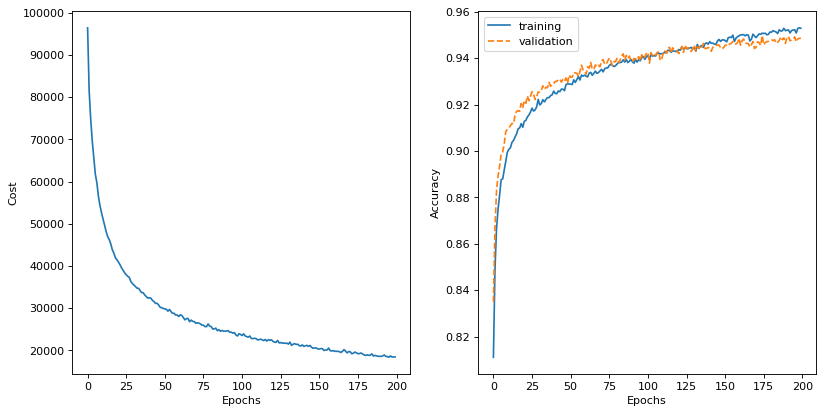

In [74]:
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,2,1)
ax.plot(range(nn.epochs), nn.eval_['cost'])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs')

ax = plt.subplot(1,2,2)
ax.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
ax.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()

## Q4. The neural network is getting pretty good results on the data. How would you improve on the results further?

<span style="color:red">''' Write down the answer in the cell markdown here (doubleclick the text)  '''</span>.